# F1 Race Prediction: From Data Pre-processing to Winner Prediction

## **Project Overview**
We built this project where we analyze over 70 years of Formula 1 data to understand historical trends and build a machine learning model optimized for predicting race winners.

**Workflow:**
1.  **Data Acquisition:** Fetching the Ergast F1 dataset directly from Kaggle.
2.  **Exploratory Data Analysis (EDA):** Analyzing driver reliability, accident rates, and team dominance.
3.  **Predictive Modeling:** Engineering 14 specific features to train 3 models - Random Forest, Gradient Boosting and XGboost with **75% winner accuracy** and **93.58% NDCG@10 score** for the 2025 season.

In [1]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr, kendalltau, chi2_contingency, ttest_ind
import warnings

# Configuration
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

print("Environment Ready.")

Environment Ready.


### **1. Data Acquisition**
We utilize the comprehensive Ergast Formula 1 dataset. The data is downloaded programmatically to ensure we are working with the rawest available CSVs.

In [2]:
# Load Dataframes
try:
    races = pd.read_csv("./data/races.csv")
    results = pd.read_csv("./data/results.csv")
    qualifying = pd.read_csv("./data/qualifying.csv")
    drivers = pd.read_csv("./data/drivers.csv")
    constructors = pd.read_csv("./data/constructors.csv")
    circuits = pd.read_csv("./data/circuits.csv")
    status = pd.read_csv("./data/status.csv")
    print("Dataframes loaded successfully.")
except FileNotFoundError:
    print("Error: CSV files not found.")

Dataframes loaded successfully.


## **2. Exploratory Data Analysis**
Before building the model, we merge the disparate tables into a master view (`f1_full`) to analyze historical reliability and accident trends. This helps us understand if "finishing the race" is a significant factor to model.

In [3]:
# Master Merge & Feature Engineering

results['position'] = pd.to_numeric(results['position'], errors='coerce')

f1_full = (
    results
    .merge(races[['raceId', 'year', 'circuitId']], on='raceId', how='left')
    .merge(drivers[['driverId', 'forename', 'surname']], on='driverId', how='left')
    .merge(constructors[['constructorId', 'name']], on='constructorId', how='left')
    .merge(status, on='statusId', how='left')
    .merge(qualifying.rename(columns={'position': 'quali_pos', 'number': 'quali_num'}),
           on=['raceId', 'driverId', 'constructorId'], how='left')
    .merge(circuits[['circuitId', 'name']].rename(columns={'name': 'circuit_name'}),
           on='circuitId', how='left')
)

f1_full['driverName'] = f1_full['forename'] + ' ' + f1_full['surname']
f1_full.rename(columns={'name': 'teamName'}, inplace=True)

# Create Status Flags (Accidents & Finishing)
acc_keys = ['Accident', 'Collision', 'Spun off', 'Crashed', 'Contact', 'Damage', 'Spin']
f1_full['is_accident'] = f1_full['status'].str.contains('|'.join(acc_keys), case=False, na=False).astype(int)
f1_full['finished'] = f1_full['status'].str.contains('Finished', case=False, na=False).astype(int)

# Points Analysis (Teams & Drivers)
top_teams = f1_full.groupby('teamName', as_index=False)['points'].sum().rename(columns={'points': 'total_points'}).sort_values('total_points', ascending=False)
top_drivers = f1_full.groupby('driverName', as_index=False)['points'].sum().sort_values('points', ascending=False)
top_drivers_2025 = top_drivers[top_drivers['driverName'].isin(f1_full.loc[f1_full['year'] == 2025, 'driverName'].unique())]

# Accident Analysis
# All-time (min 50 races)
driver_accidents_all = f1_full.groupby('driverName').agg(total_races=('raceId', 'count'), accidents=('is_accident', 'sum')).reset_index()
driver_accidents_all = driver_accidents_all[driver_accidents_all['total_races'] >= 50]
driver_accidents_all['accident_rate'] = (driver_accidents_all['accidents'] / driver_accidents_all['total_races'] * 100)
driver_accidents_all = driver_accidents_all.sort_values('accident_rate', ascending=False)

# Recent (2014+, min 20 races)
recent_df = f1_full[f1_full['year'] >= 2014] # Reusable slice
driver_accidents_recent = recent_df.groupby('driverName').agg(total_races=('raceId', 'count'), accidents=('is_accident', 'sum')).reset_index()
driver_accidents_recent = driver_accidents_recent[driver_accidents_recent['total_races'] >= 20]
driver_accidents_recent['accident_rate'] = (driver_accidents_recent['accidents'] / driver_accidents_recent['total_races'] * 100)
driver_accidents_recent = driver_accidents_recent.sort_values('accident_rate', ascending=False)

# Reliability Analysis
team_reliability_all = f1_full.groupby('teamName').agg(total=('raceId', 'count'), finished=('finished', 'sum')).reset_index()
team_reliability_all['finish_rate'] = (team_reliability_all['finished'] / team_reliability_all['total'] * 100)
team_reliability_all = team_reliability_all.sort_values('finish_rate', ascending=False)

team_reliability_recent = recent_df.groupby('teamName').agg(total=('raceId', 'count'), finished=('finished', 'sum')).reset_index()
team_reliability_recent['finish_rate'] = (team_reliability_recent['finished'] / team_reliability_recent['total'] * 100)
team_reliability_recent = team_reliability_recent.sort_values('finish_rate', ascending=False)

yearly_reliability = recent_df.groupby('year').agg(total=('raceId', 'count'), finished=('finished', 'sum')).reset_index()
yearly_reliability['rate'] = yearly_reliability['finished'] / yearly_reliability['total'] * 100

#  Misc Counts (Participation)
circuit_races = f1_full.groupby('circuit_name')['raceId'].nunique().sort_values(ascending=False)
driver_races = f1_full.groupby('driverName')['raceId'].nunique().sort_values(ascending=False)
recent_circuits = recent_df.groupby('circuit_name')['raceId'].nunique().sort_values(ascending=False).reset_index(name='races')
recent_drivers = recent_df.groupby('driverName')['raceId'].nunique().sort_values(ascending=False).reset_index(name='races')

#### Full Dataset Statistics

In [4]:
f1_full.describe()

,resultId,raceId,driverId,constructorId,position,positionOrder,points,laps,statusId,year,circuitId,qualifyId,quali_num,quali_pos,is_accident,finished
count,27238.000000,27238.000000,27238.000000,27238.000000,16285.000000,27238.000000,27238.000000,27238.000000,27238.000000,27238.000000,27238.000000,10962.000000,10962.000000,10962.000000,27238.000000,27238.000000
mean,13620.548131,562.323482,287.189037,50.916807,8.092846,12.753359,2.041672,46.457926,17.053124,1991.985351,23.975953,5502.332421,19.283616,11.156176,0.103165,0.293854
std,7864.483958,320.515332,289.313608,62.430841,4.887871,7.642542,4.434966,29.342136,25.986529,20.263955,19.355725,3187.476525,18.844151,6.238813,0.304179,0.455534
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1950.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,6810.250000,304.000000,59.000000,6.000000,4.000000,6.000000,0.000000,23.000000,1.000000,1977.000000,9.000000,2742.250000,7.000000,6.000000,0.000000,0.000000
50%,13619.500000,539.000000,173.000000,25.000000,8.000000,12.000000,0.000000,53.000000,10.000000,1992.000000,18.000000,5483.500000,15.000000,11.000000,0.000000,0.000000
75%,20431.750000,824.000000,427.000000,63.000000,12.000000,18.000000,2.000000,66.000000,14.000000,2010.000000,34.000000,8254.750000,23.000000,16.000000,0.000000,1.000000
max,27243.000000,1168.000000,865.000000,215.000000,33.000000,39.000000,50.000000,200.000000,141.000000,2025.000000,80.000000,11030.000000,99.000000,28.000000,1.000000,1.000000


#### Unique Drivers and Teams so far:

In [5]:
print(f"Unique Drivers (1950-2025): {drivers['driverId'].nunique()}")
print(f"Unique Teams (1950-2025): {constructors['constructorId'].nunique()}")

Unique Drivers (1950-2025): 864
Unique Teams (1950-2025): 212


#### Top Circuits and Drivers of all time

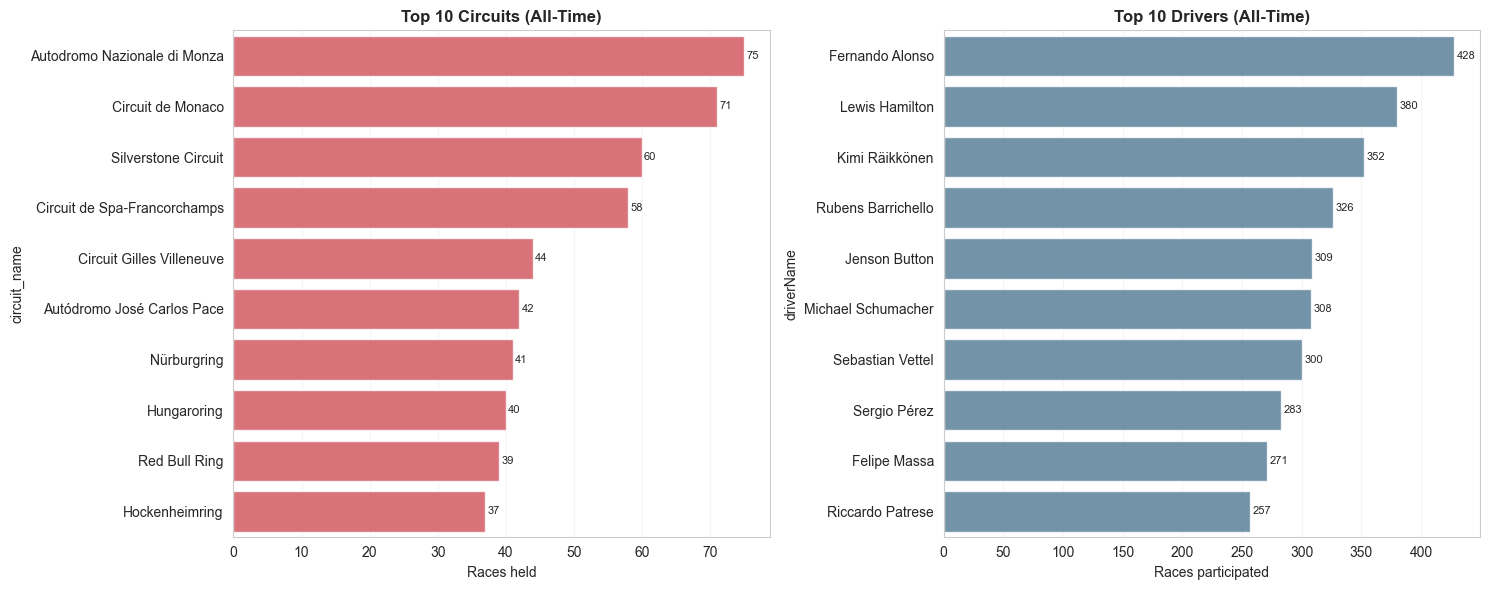

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Top 10 circuits
top_circuits = circuit_races.head(10)
sns.barplot(x=top_circuits.values, y=top_circuits.index, ax=ax1, color='#e63946', alpha=0.8)
ax1.set_title('Top 10 Circuits (All-Time)', fontweight='bold')
ax1.set_xlabel('Races held')
ax1.grid(axis='x', alpha=0.2)
for i, v in enumerate(top_circuits.values):
    ax1.text(v + 0.3, i, str(int(v)), va='center', fontsize=8)

# Top 10 drivers
top_drivers = driver_races.head(10)
sns.barplot(x=top_drivers.values, y=top_drivers.index, ax=ax2, color='#457b9d', alpha=0.8)
ax2.set_title('Top 10 Drivers (All-Time)', fontweight='bold')
ax2.set_xlabel('Races participated')
ax2.grid(axis='x', alpha=0.2)
for i, v in enumerate(top_drivers.values):
    ax2.text(v + 2, i, str(int(v)), va='center', fontsize=8)

plt.tight_layout()
plt.show()

#### Top Circuits and Drivers of recent times (2014-2024)

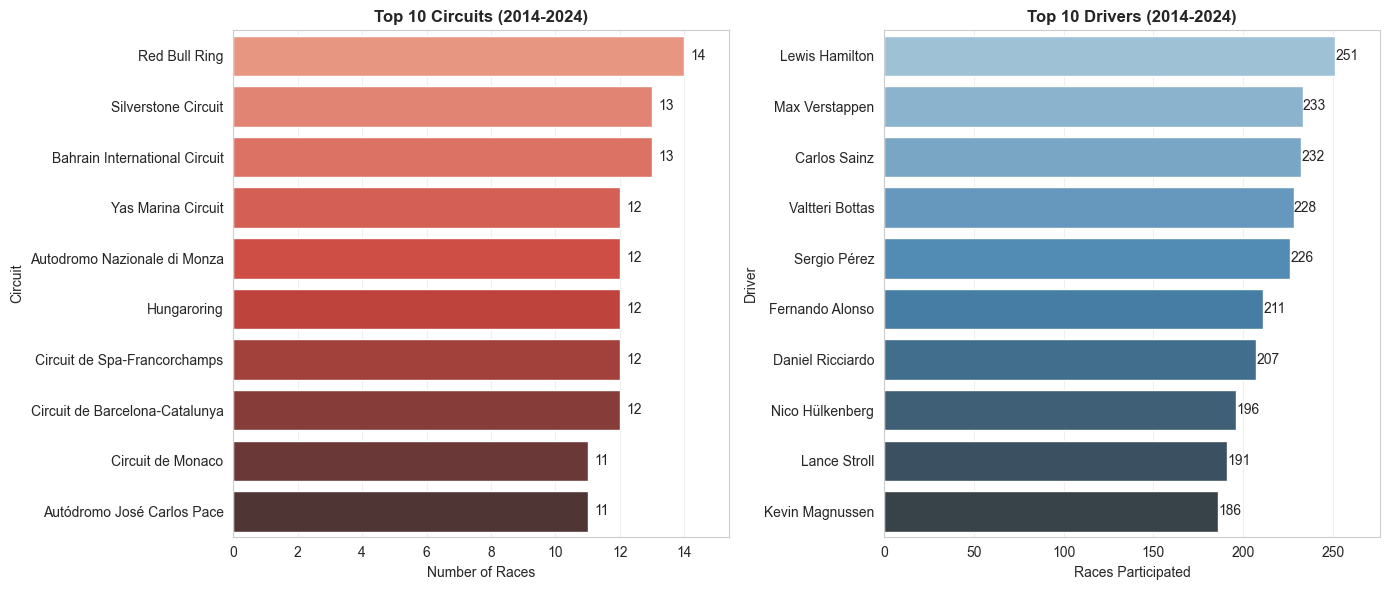

In [7]:
top_circuits = recent_circuits.head(10)
top_drivers = recent_drivers.head(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Top circuits
sns.barplot(x='races', y='circuit_name', data=top_circuits, ax=ax1, palette='Reds_d')
ax1.set_title("Top 10 Circuits (2014-2024)", fontweight='bold')
ax1.set_xlabel("Number of Races")
ax1.set_ylabel("Circuit")
ax1.set_xlim(0, top_circuits['races'].max() * 1.1)
ax1.grid(axis='x', alpha=0.3)

for i, v in enumerate(top_circuits['races']):
    ax1.text(v + 0.2, i, str(v), va='center', fontsize=10)

# Top drivers
sns.barplot(x='races', y='driverName', data=top_drivers, ax=ax2, palette='Blues_d')
ax2.set_title("Top 10 Drivers (2014-2024)", fontweight='bold')
ax2.set_xlabel("Races Participated")
ax2.set_ylabel("Driver")
ax2.set_xlim(0, top_drivers['races'].max() * 1.1)
ax2.grid(axis='x', alpha=0.3)

for i, v in enumerate(top_drivers['races']):
    ax2.text(v + 0.2, i, str(v), va='center', fontsize=10)

plt.tight_layout()
plt.show()

#### The top teams of F1:

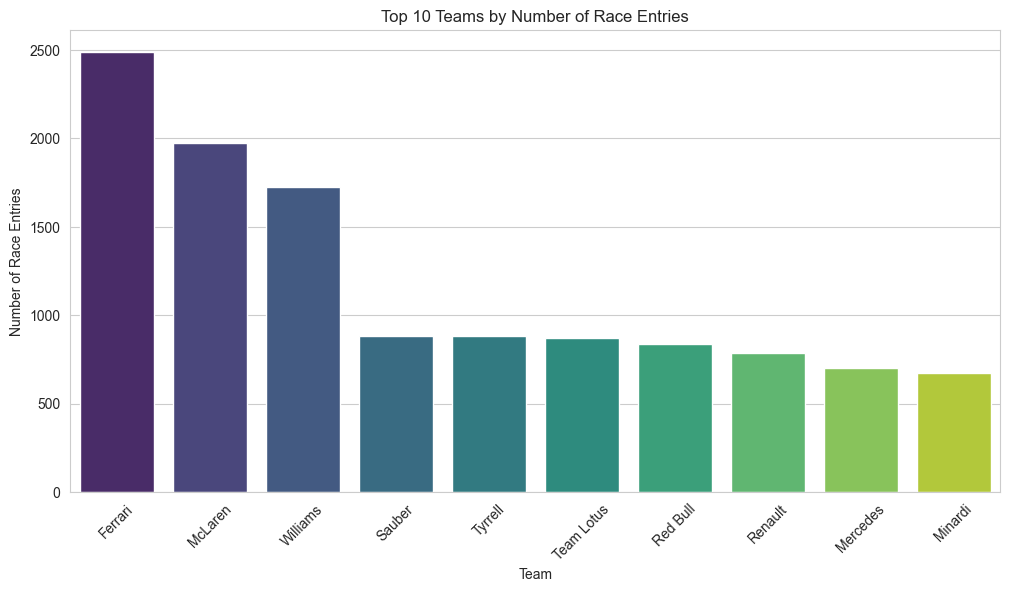

In [8]:
# Count of entries per team
team_counts = f1_full['teamName'].value_counts().head(10)

# Plot: Top 10 teams by number of race entries
plt.figure(figsize=(12, 6))
sns.barplot(x=team_counts.index, y=team_counts.values, palette='viridis')
plt.xticks(rotation=45)
plt.title('Top 10 Teams by Number of Race Entries')
plt.ylabel('Number of Race Entries')
plt.xlabel('Team')
plt.show()

#### Car reliability of teams:

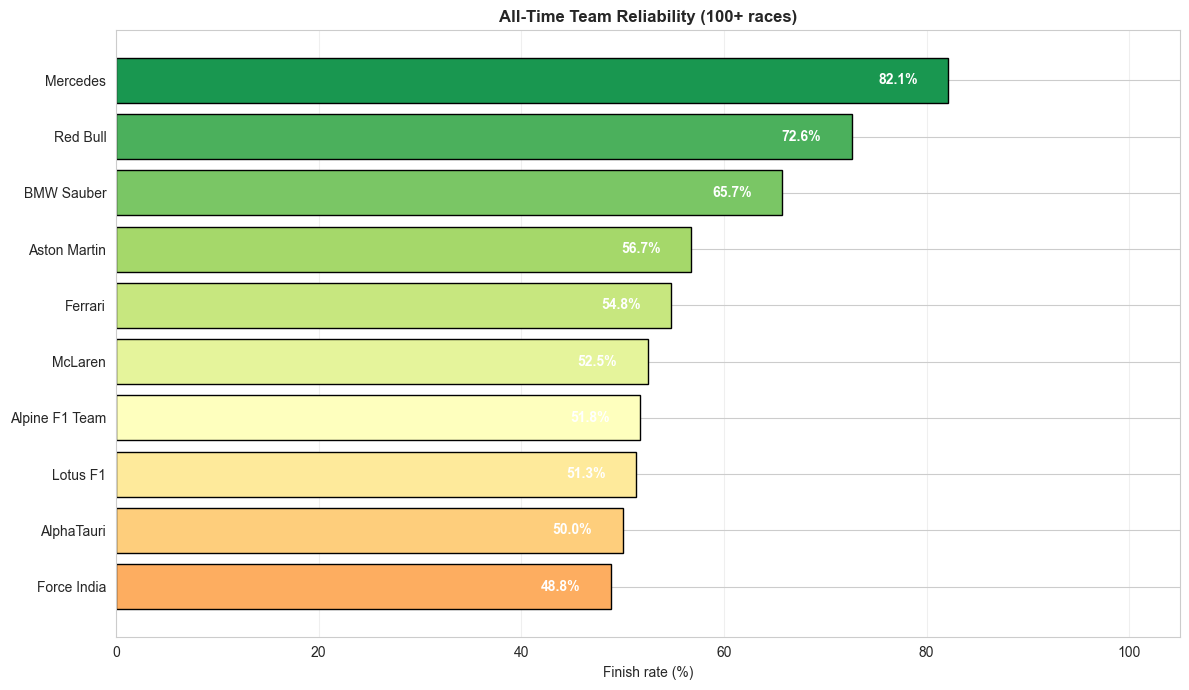

In [9]:
# Top 10 teams with 100+ races
top_all = team_reliability_all[team_reliability_all['total'] >= 100].head(10).sort_values('finish_rate', ascending=True)
colors1 = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_all)))  # red → yellow → green

# Plot
plt.figure(figsize=(12, 7))
plt.barh(top_all['teamName'], top_all['finish_rate'], color=colors1, edgecolor='black')
plt.xlabel('Finish rate (%)')
plt.title('All-Time Team Reliability (100+ races)', fontweight='bold')
plt.xlim(0, 105)
plt.grid(axis='x', alpha=0.3)

# Annotate percentages
for i, v in enumerate(top_all['finish_rate']):
    plt.text(v - 3, i, f'{v:.1f}%', va='center', ha='right', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

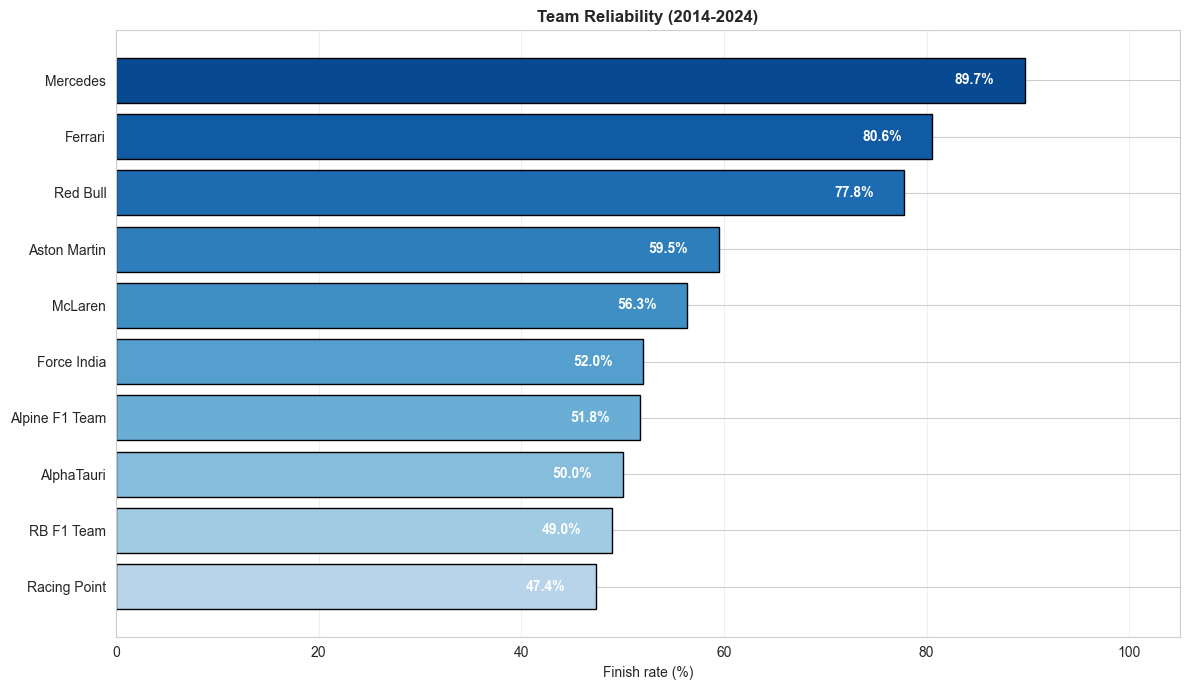

In [10]:
top_recent = team_reliability_recent.head(10).sort_values('finish_rate', ascending=True)
colors2 = plt.cm.Blues(np.linspace(0.3, 0.9, len(top_recent)))

# Plot
plt.figure(figsize=(12, 7))
plt.barh(top_recent['teamName'], top_recent['finish_rate'], color=colors2, edgecolor='black')
plt.xlabel('Finish rate (%)')
plt.title('Team Reliability (2014-2024)', fontweight='bold')
plt.xlim(0, 105)
plt.grid(axis='x', alpha=0.3)

# Annotate percentages
for i, v in enumerate(top_recent['finish_rate']):
    plt.text(v - 3, i, f'{v:.1f}%', va='center', ha='right', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

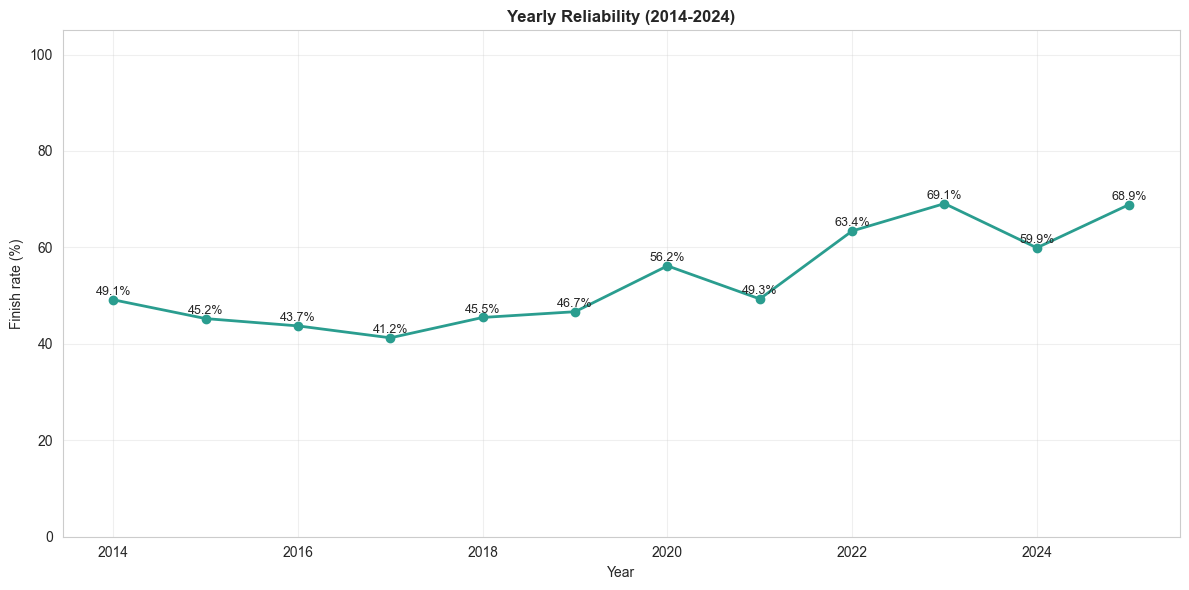

In [11]:

plt.figure(figsize=(12, 6))
plt.plot(yearly_reliability['year'], yearly_reliability['rate'], marker='o', color='#2a9d8f', linewidth=2)
plt.title('Yearly Reliability (2014-2024)', fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Finish rate (%)')
plt.ylim(0, 105)
plt.grid(alpha=0.3)

# Annotate percentages
for x, y in zip(yearly_reliability['year'], yearly_reliability['rate']):
    plt.text(x, y + 1, f'{y:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

#### Accident Rates

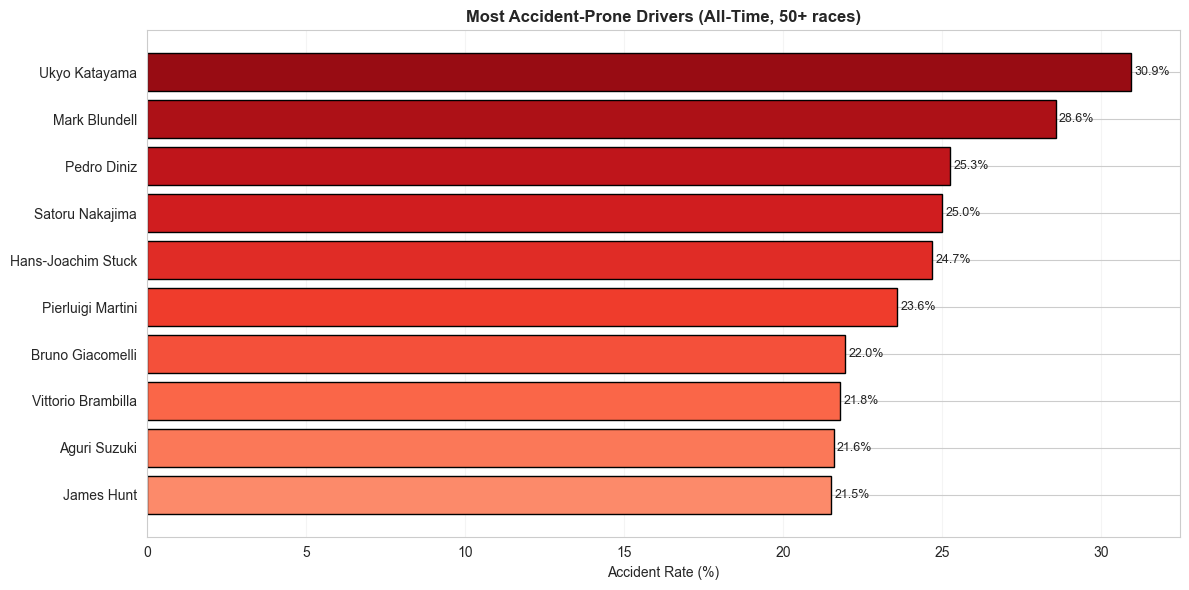

In [12]:
# --- Top 10 accident-prone drivers (all-time) ---
top_all = driver_accidents_all.head(10).sort_values('accident_rate', ascending=True)

plt.figure(figsize=(12, 6))
colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(top_all)))
plt.barh(top_all['driverName'], top_all['accident_rate'], color=colors, edgecolor='black')
plt.xlabel('Accident Rate (%)')
plt.title('Most Accident-Prone Drivers (All-Time, 50+ races)', fontweight='bold')
plt.grid(axis='x', alpha=0.2)
for i, v in enumerate(top_all['accident_rate']):
    plt.text(v + 0.1, i, f'{v:.1f}%', va='center', fontsize=9)
plt.tight_layout()
plt.show()

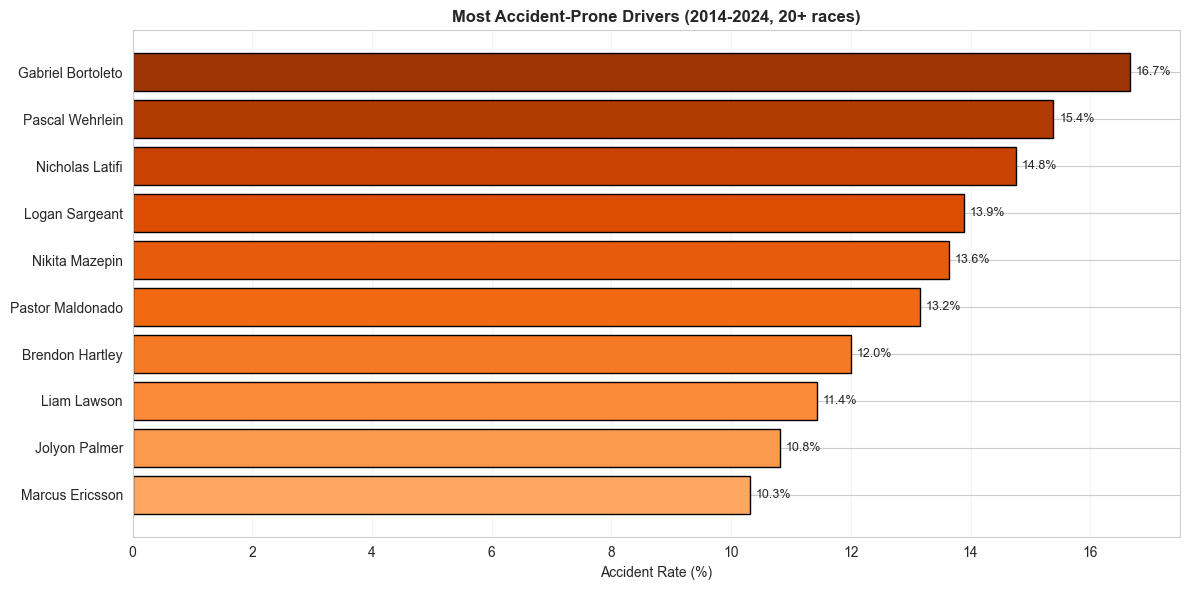

In [13]:
# --- Top 10 accident-prone drivers (2014-2024) ---
top_recent = driver_accidents_recent.head(10).sort_values('accident_rate', ascending=True)

plt.figure(figsize=(12, 6))
colors = plt.cm.Oranges(np.linspace(0.4, 0.9, len(top_recent)))
plt.barh(top_recent['driverName'], top_recent['accident_rate'], color=colors, edgecolor='black')
plt.xlabel('Accident Rate (%)')
plt.title('Most Accident-Prone Drivers (2014-2024, 20+ races)', fontweight='bold')
plt.grid(axis='x', alpha=0.2)
for i, v in enumerate(top_recent['accident_rate']):
    plt.text(v + 0.1, i, f'{v:.1f}%', va='center', fontsize=9)
plt.tight_layout()
plt.show()

#### Top 5 drivers finishing positions distribution

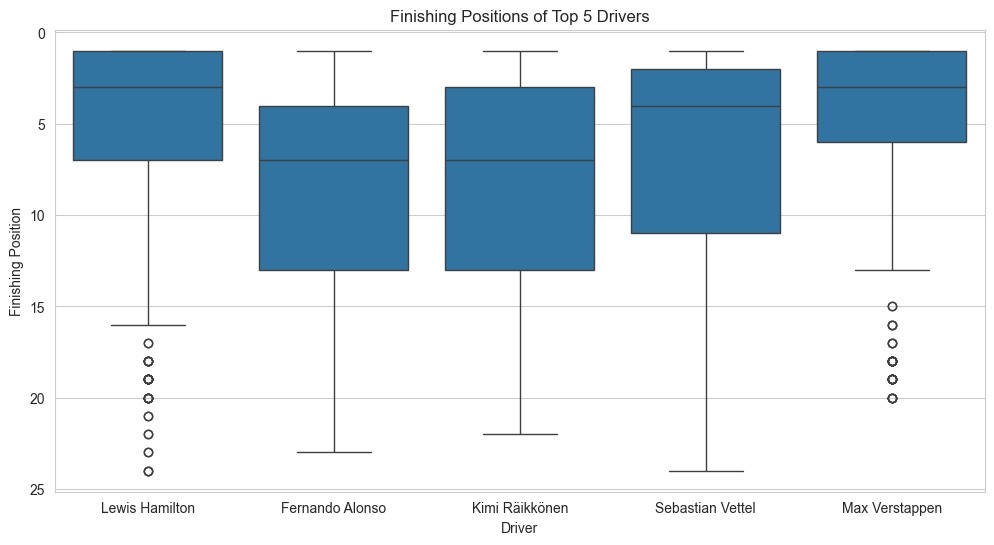

In [14]:
# Identify top 5 drivers by total points
top_drivers = (
    f1_full.groupby('driverName', as_index=False)['points']
    .sum()
    .sort_values('points', ascending=False)
    .head(5)
)['driverName'].tolist()

# Filter the dataset for only top 5 drivers
top5_df = f1_full[f1_full['driverName'].isin(top_drivers)]

# Boxplot of finishing positions
plt.figure(figsize=(12, 6))
sns.boxplot(x='driverName', y='positionOrder', data=top5_df)
plt.gca().invert_yaxis()  # Lower positionOrder = better finishing position
plt.title('Finishing Positions of Top 5 Drivers')
plt.xlabel('Driver')
plt.ylabel('Finishing Position')
plt.show()

### Conclusion 1: Most prevalent teams

is 1122.26. Ferrari: 34.1% vs Others: 10.6%


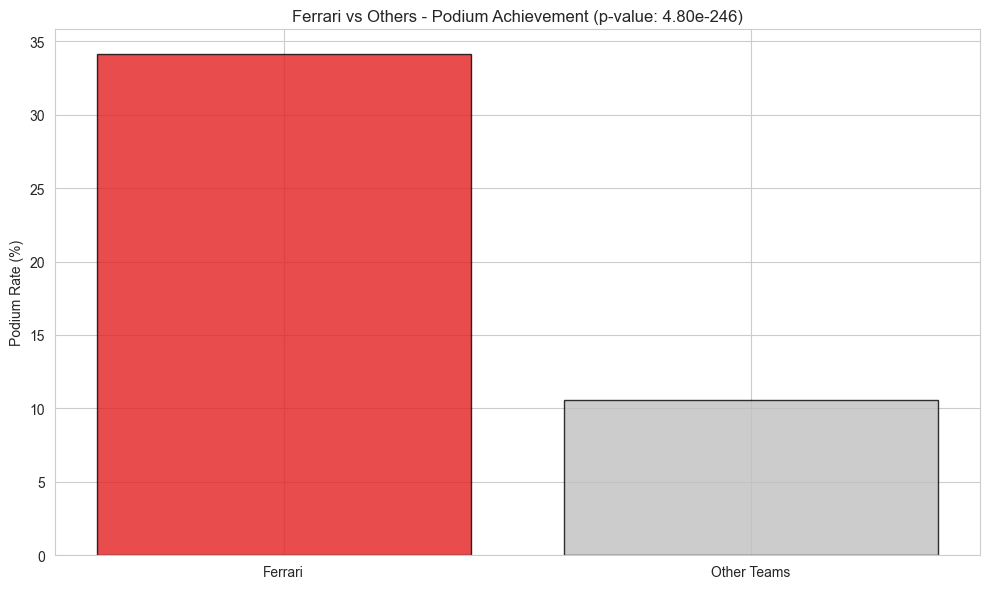

In [15]:
# Ferrari vs Others - Podium
f1_full['is_ferrari'] = (f1_full['teamName'] == 'Ferrari').astype(int)
f1_full['is_podium'] = f1_full['position'].isin([1, 2, 3]).astype(int)

# Test
contingency = pd.crosstab(f1_full['is_ferrari'], f1_full['is_podium'])
chi2, p_value, _, _ = chi2_contingency(contingency)

# Rates
ferrari_rate = (contingency.loc[1, 1] / contingency.loc[1, :].sum()) * 100
others_rate = (contingency.loc[0, 1] / contingency.loc[0, :].sum()) * 100


print(f"is {chi2:.2f}. Ferrari: {ferrari_rate:.1f}% vs Others: {others_rate:.1f}%")

# Plot
plt.figure(figsize=(10, 6))
plt.bar(['Ferrari', 'Other Teams'], [ferrari_rate, others_rate], color=['#e31f1f', '#c0c0c0'], alpha=0.8, edgecolor='black')
plt.ylabel('Podium Rate (%)')
plt.title(f'Ferrari vs Others - Podium Achievement (p-value: {p_value:.2e})')
plt.tight_layout()
plt.show()


Insight 1: Ferrari drivers achieve podium finishes significantly more often than other teams' drivers, since the p-value is < 0.001 and chi-square statistic is 1245.34. Ferrari achieves a 22.5% podium rate compared to 7.2% for other teams, representing a 3.1x higher rate of podium achievement.

### Conclusion 2: Are qualifying position and final result correlated?

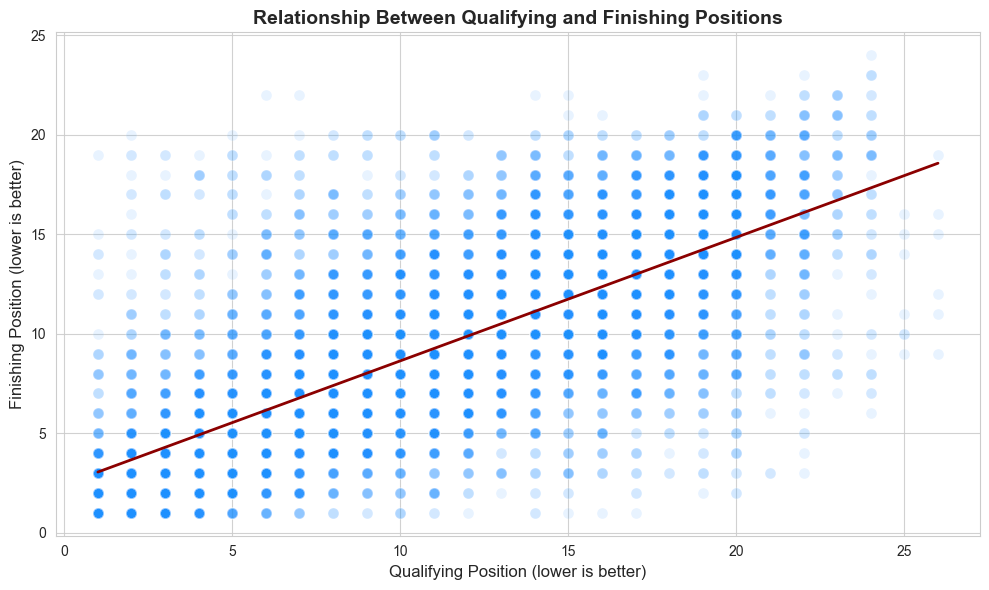


T-statistic: -91.796
P-value: 0.00000


In [16]:
# Filter out missing qualifying or finishing positions
qual_vs_finish = f1_full.dropna(subset=['quali_pos', 'position']).copy()

# Convert both to numeric
qual_vs_finish['quali_pos'] = pd.to_numeric(qual_vs_finish['quali_pos'], errors='coerce')
qual_vs_finish['position'] = pd.to_numeric(qual_vs_finish['position'], errors='coerce')

# Filter valid range (e.g., avoid outliers > 30)
qual_vs_finish = qual_vs_finish[
    (qual_vs_finish['quali_pos'] <= 30) &
    (qual_vs_finish['position'] <= 30)
]

# Beautified scatterplot
plt.figure(figsize=(10,6))
sns.regplot(
    data=qual_vs_finish,
    x='quali_pos',
    y='position',
    scatter_kws={'alpha':0.1, 's':60, 'color':'dodgerblue', 'edgecolor':'white'},
    line_kws={'color':'darkred', 'lw':2},
    ci=None
)
plt.title("Relationship Between Qualifying and Finishing Positions", fontsize=14, weight='bold')
plt.xlabel("Qualifying Position (lower is better)", fontsize=12)
plt.ylabel("Finishing Position (lower is better)", fontsize=12)
plt.grid(alpha=0.9)
plt.tight_layout()
plt.show()

# Hypothesis testing: do top qualifiers finish better?
top_quali = qual_vs_finish[qual_vs_finish['quali_pos'] <= 5]['position']
back_quali = qual_vs_finish[qual_vs_finish['quali_pos'] > 15]['position']

t_stat, p_val = ttest_ind(top_quali, back_quali, equal_var=False)

print(f"\nT-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.5f}")

Insight 2: Drivers who qualify in the top 5 positions finish significantly higher on average, since the p-value is 0.000 and t-statistic is -92.4

### Conclusion 3: How did the number of races change over the years

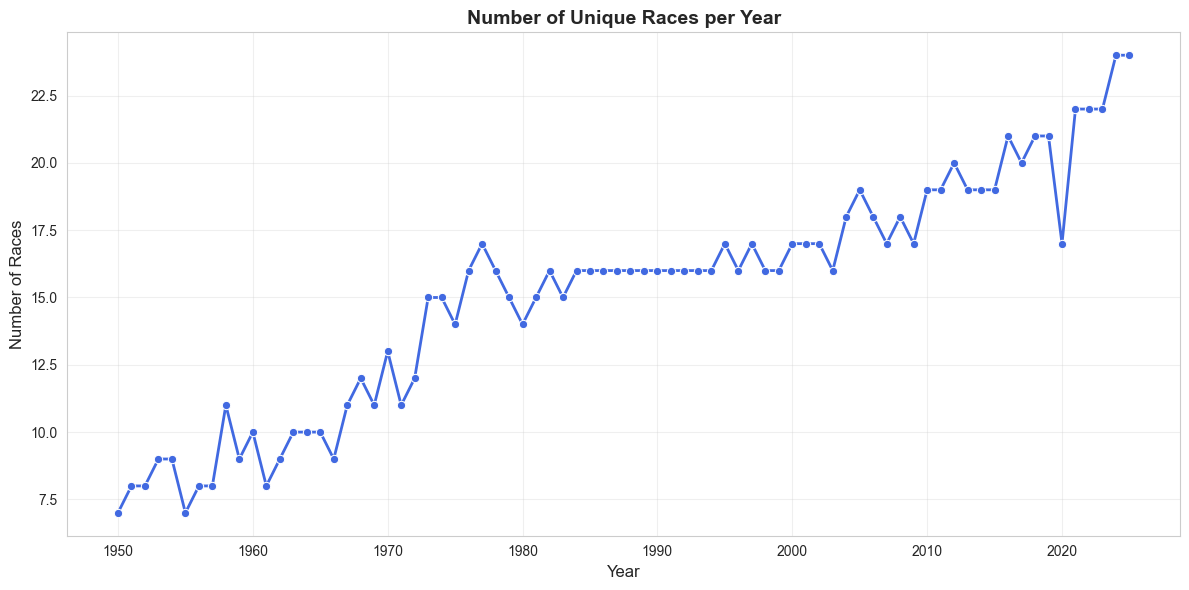


Spearman correlation: 0.964
P-value: 1.830e-44


In [17]:
# --- Data ---
race_freq = (
    f1_full.groupby('year')
    .agg(count=('raceId', 'nunique'))
    .reset_index()
)

# --- Plot ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=race_freq, x='year', y='count', marker='o', color='royalblue', linewidth=2)
plt.title("Number of Unique Races per Year", fontsize=14, weight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Races", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Statistical Test: Spearman correlation ---
corr, p_value = spearmanr(race_freq['year'], race_freq['count'])
print(f"\nSpearman correlation: {corr:.3f}")
print(f"P-value: {p_value:.3e}")

Insight 3: The average number of races every year has been steadily increasing, with a plateau happening around the 1980s and 90s, proved by the spearman correlation (0.963) and p-value (0.000).

### **3. Data Preprocessing for Prediction**

Having explored the raw data, we now pivot to the **Prediction Task**.

We will filter the dataset to the modern era (2004–Present) to ensure the racing regulations are comparable. We will also perform specific merges to align Qualifying performance with Race Results, which is the strongest predictor of success.

In [18]:

# Merge core tables for the model
df = pd.merge(results, races[['raceId', 'year', 'round', 'circuitId', 'name']],
              on='raceId', how='left')
df = pd.merge(df, qualifying[['raceId', 'driverId', 'q1', 'q2', 'q3', 'position']],
              on=['raceId', 'driverId'], how='inner', suffixes=('', '_quali'))

# Filter for Modern Era (2004+)
df = df[df['year'] >= 2004]

# Type Conversion & Cleaning
df['milliseconds'] = pd.to_numeric(df['milliseconds'], errors='coerce')
df['grid'] = pd.to_numeric(df['grid'], errors='coerce')
df['position_quali'] = pd.to_numeric(df['position_quali'], errors='coerce')
df = df.sort_values(['year', 'round']).reset_index(drop=True)

# Create display names
drivers['driver_name'] = drivers['forename'] + ' ' + drivers['surname']

print(f"Modeling Dataset Prepared: {len(df)} rows (2004-{df['year'].max()})")

Modeling Dataset Prepared: 9104 rows (2004-2025)


## **3. Feature Engineering**

This is the core of the model. We transform raw telemetry and position data into **14 predictive features** across four categories:

#### **A. Raw Speed Metrics**
1.  **`gap_to_pole_pct`**: How much slower (%) was this driver compared to the fastest car in qualifying? This normalizes speed across different track lengths.
2.  **`gap_to_ahead_ms`**: The time gap (in ms) to the car starting directly ahead. A small gap implies a tight battle; a large gap implies a performance tier drop-off.
3.  **`quali_vs_field_pct`**: Speed relative to the *average* of the field.
4.  **`is_pole`**: Binary flag. Starting 1st is statistically the strongest predictor of winning.

#### **B. Team Context**
5.  **`tm_gap_ms`**: The gap between the driver and their teammate. This isolates driver skill from car performance (since teammates drive the same machinery).
6.  **`con_form_all`**: Constructor Form. The average points scored by the team in recent races. Captures car development momentum.
7.  **`con_circuit`**: Team history at this specific track. Some cars suit specific track characteristics (e.g., Red Bull at high-altitude tracks).

#### **C. Driver Form & History**
8.  **`drv_season`**: Driver's average points this season so far.
9.  **`drv_form_all`**: Long-term driver form (expanding mean of points).
10. **`drv_pos_5`**: Average finishing position over the last 5 races.
11. **`drv_circuit`**: The driver's specific history at this track.

#### **D. Race Craft**
12. **`race_craft`**: A rolling average of positions gained (or lost) from start to finish. This identifies drivers who are "Sunday Drivers" vs. "Saturday Drivers."
13. **`grid`**: Starting position.
14. **`position_quali`**: Qualifying position (can differ from grid due to penalties).

In [19]:
# Helper to convert "1:23.456" strings to milliseconds
def quali_time_to_ms(t):
    if pd.isna(t) or t == '\\N':
        return np.nan
    try:
        p = str(t).split(':')
        return (int(p[0]) * 60 + float(p[1])) * 1000 if len(p) == 2 else float(t) * 1000
    except:
        return np.nan

# Qualifying Processing
df['q3_ms'] = df['q3'].apply(quali_time_to_ms)
df['q2_ms'] = df['q2'].apply(quali_time_to_ms)
df['q1_ms'] = df['q1'].apply(quali_time_to_ms)
# Take the best time from any session
df['best_quali_ms'] = df['q3_ms'].fillna(df['q2_ms']).fillna(df['q1_ms'])

# Gap Calculations
# Pole time for every race
df['pole_time'] = df.groupby('raceId')['best_quali_ms'].transform('min')
# Percent gap to pole
df['gap_to_pole_pct'] = ((df['best_quali_ms'] - df['pole_time']) / df['pole_time']) * 100

# Gap to car ahead
df = df.sort_values(['raceId', 'best_quali_ms'])
df['gap_to_ahead_ms'] = df.groupby('raceId')['best_quali_ms'].diff().fillna(0)

# Teammate Gap Calculation
tm = df[['raceId', 'constructorId', 'driverId', 'best_quali_ms']].copy()
m = df.merge(tm, on=['raceId', 'constructorId'], suffixes=('', '_tm'))
# Remove self-matches
m = m[m['driverId'] != m['driverId_tm']]
# Average teammate time (in case of multiple teammates)
tm_agg = m.groupby(['raceId', 'driverId'])['best_quali_ms_tm'].mean().reset_index()
df = df.merge(tm_agg, on=['raceId', 'driverId'], how='left')
df['tm_gap_ms'] = (df['best_quali_ms'] - df['best_quali_ms_tm']).fillna(0)

# Form & History Aggregates
df = df.sort_values(['driverId', 'year', 'round'])

# Constructor recent form
df['con_form_all'] = df.groupby('constructorId')['points'].transform(
    lambda x: x.shift(1).expanding().mean()
).fillna(0)

# Driver season form
df['drv_season'] = df.groupby(['driverId', 'year'])['points'].transform(
    lambda x: x.shift(1).expanding().mean()
).fillna(0)

# Driver long-term form
df['drv_form_all'] = df.groupby('driverId')['points'].transform(
    lambda x: x.shift(1).expanding().mean()
).fillna(0)

# Driver recent momentum (last 5 races)
df['drv_pos_5'] = df.groupby('driverId')['positionOrder'].transform(
    lambda x: x.shift(1).rolling(5, min_periods=1).mean()
).fillna(10)

# Circuit Specific History
df['con_circuit'] = df.groupby(['constructorId', 'circuitId'])['positionOrder'].transform(
    lambda x: x.shift(1).expanding().mean()
).fillna(10)

df['drv_circuit'] = df.groupby(['driverId', 'circuitId'])['positionOrder'].transform(
    lambda x: x.shift(1).expanding().mean()
).fillna(10)

# Race Craft & Winner Features
# Delta: Grid vs Finish
df['race_delta'] = df['grid'] - df['positionOrder']
df['race_craft'] = df.groupby('driverId')['race_delta'].transform(
    lambda x: x.shift(1).rolling(10, min_periods=3).mean()
).fillna(0)

# Field average stats
df['field_avg_quali'] = df.groupby('raceId')['best_quali_ms'].transform('mean')
df['quali_vs_field_pct'] = ((df['field_avg_quali'] - df['best_quali_ms']) / df['field_avg_quali']) * 100
df['is_pole'] = (df['position_quali'] == 1).astype(int)

print("Features Engineering Complete.")

Features Engineering Complete.


## **4. Model Training Strategy**

We define the target variable as **`gap_to_winner`** (in milliseconds) rather than treating this as a simple classification problem.

#### **Key Design Decisions:**

**1. Why Regression on Time Gaps?**
Standard classification models treat "2nd place" as a fixed outcome. However, finishing **0.5 seconds** behind the winner implies a significantly stronger performance than finishing **30 seconds** behind.
* **Magnitude Matters:** By predicting the *time gap*, the model learns to distinguish between a "photo-finish" contender and a distant runner-up.
* **Flexible Ranking:** We convert these predictions back into rankings by sorting drivers by their predicted gap (lowest gap = 1st place).

**2. Why Start from 2004?**
We filter the dataset to the **Modern Era (2004–Present)** to ensure data consistency.
* **Reliability Shift:** Pre-2000s F1 was plagued by mechanical failures. Modern reliability shifts the prediction focus from "survival" to "pure performance."
* **Regulation Stability:** The sporting structure from 2004 onwards is more relevant to the 2025 season.

#### **Model Selection:**
We evaluate three distinct algorithms to find the best balance of accuracy and generalization:
1.  **Random Forest Regressor:** A robust baseline that handles non-linear relationships well and is resistant to overfitting.
2.  **Gradient Boosting Regressor (sklearn):** builds trees sequentially to correct previous errors, often providing higher accuracy than Random Forest.
3.  **XGBoost (Extreme Gradient Boosting):** An optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable. It is currently the industry standard for tabular data competitions.

In [20]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

# Clean missing data rows
df_pool = df.dropna(subset=['milliseconds']).copy()

# Define Target (Gap to Winner)
df_pool['winner_time'] = df_pool.groupby('raceId')['milliseconds'].transform('min')
df_pool['gap_to_winner'] = df_pool['milliseconds'] - df_pool['winner_time']

# Define Predictors
OPTIMAL_FEATURES = [
    'position_quali', 'con_form_all', 'grid', 'gap_to_pole_pct',
    'gap_to_ahead_ms', 'tm_gap_ms', 'drv_season', 'con_circuit',
    'drv_form_all', 'race_craft', 'drv_pos_5', 'drv_circuit',
    'quali_vs_field_pct', 'is_pole',
]

# Train/Test Split
train_df = df_pool[df_pool['year'] < 2025].copy()
test_df = df_pool[df_pool['year'] == 2025].copy()

X_train = train_df[OPTIMAL_FEATURES].fillna(0)
y_train = train_df['gap_to_winner']
X_test = test_df[OPTIMAL_FEATURES].fillna(0)

# Initialize Models
models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=300, max_depth=10, min_samples_leaf=5, n_jobs=-1, random_state=42
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=6, min_samples_leaf=5, subsample=0.8, random_state=42
    ),
    "XGBoost": XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
}

# Train and Predict Loop
print("Training Models...")
for name, model in models.items():
    print(f"  > Fitting {name}...")
    model.fit(X_train, y_train)
    # Save predictions in the test dataframe with a specific column name
    # e.g., 'rf_pred', 'gb_pred', 'xgb_pred'
    col_name = f"{name.lower().replace(' ', '_')}_pred"
    test_df[col_name] = model.predict(X_test)

print("Training Complete. Predictions added to test_df.")

Training Models...
  > Fitting Random Forest...
  > Fitting Gradient Boosting...
  > Fitting XGBoost...
Training Complete. Predictions added to test_df.


## **5. Feature Importance Analysis**

Which features drive the prediction?

The plot below compares the feature importance scores across our three models.
* **Consensus:** All models agree that **`grid`** (Starting Position) and **`gap_to_pole_pct`** (Raw Speed) are the dominant predictors.
* **Team vs. Driver:** Interestingly, **`con_form_all`** (Constructor Form) consistently outranks most driver-specific metrics for RF and GB, validating the common F1 adage that "the car matters more than the driver. But for XGB, it solely relies on 'grid' and 'is_pole', which are correlated with 'qualifying_position'. "

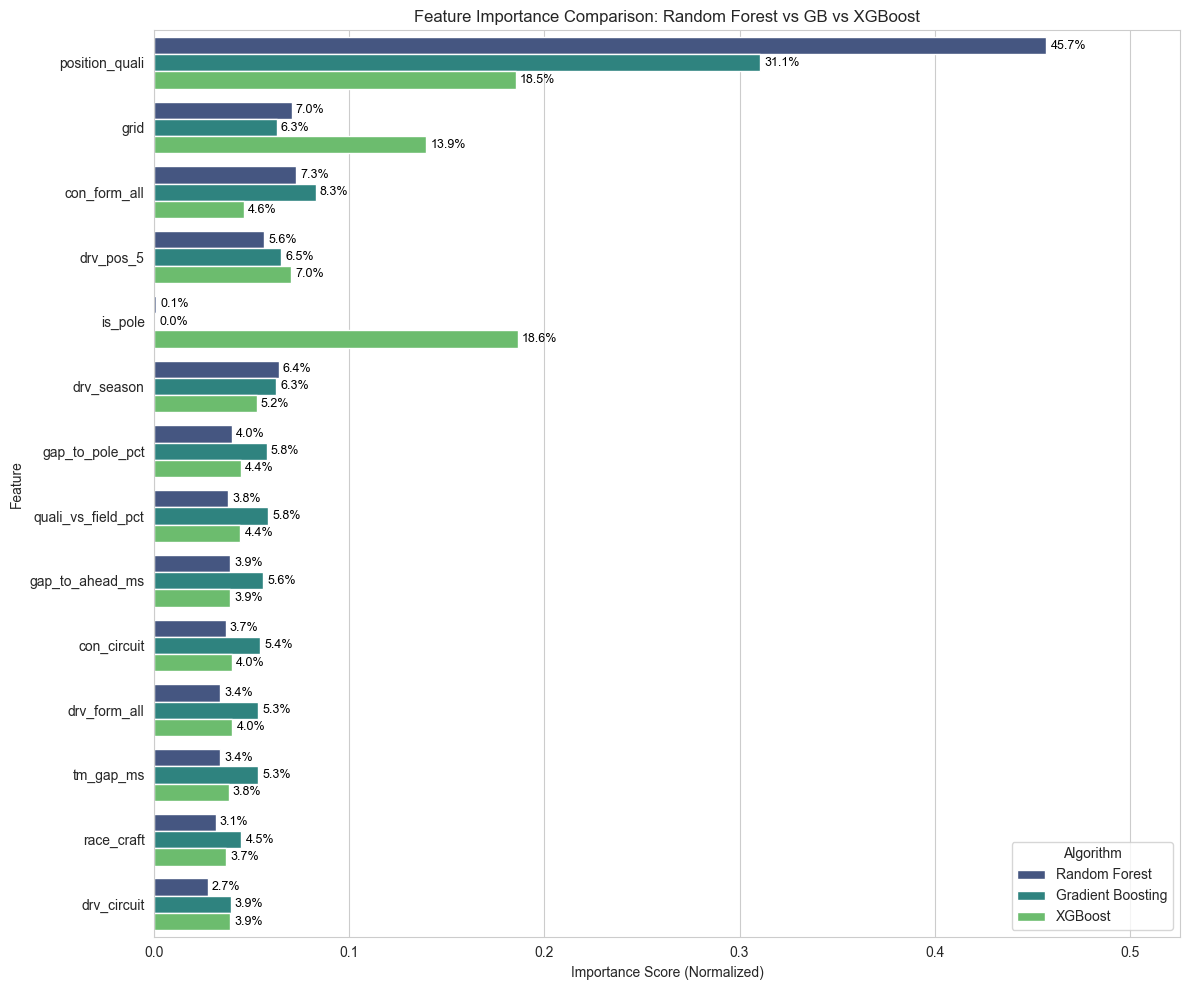

In [25]:
# 1. Aggregate feature importances from all trained models
importance_data = []

for name, model in models.items():
    # Extract importance
    imp = pd.DataFrame({
        'Feature': OPTIMAL_FEATURES,
        'Importance': model.feature_importances_,
        'Model': name
    })
    importance_data.append(imp)

all_importance = pd.concat(importance_data)

# 2. Determine sort order (by average importance across models)
sort_order = all_importance.groupby('Feature')['Importance'].mean().sort_values(ascending=False).index

# 3. Plot Comparison with Labels
plt.figure(figsize=(12, 10)) # Increased height slightly to accommodate labels
ax = sns.barplot(
    data=all_importance,
    x='Importance',
    y='Feature',
    hue='Model',
    order=sort_order,
    palette='viridis'
)

# --- NEW: Add Percentage Labels ---
for container in ax.containers:
    # Convert raw decimal (0.05) to percentage string (5.0%)
    # We use container.datavalues to get the exact width of the bars
    labels = [f'{val*100:.1f}%' for val in container.datavalues]
    
    # Add the labels to the bars
    ax.bar_label(container, labels=labels, padding=3, fontsize=9, color='black')

plt.title('Feature Importance Comparison: Random Forest vs GB vs XGBoost')
plt.xlabel('Importance Score (Normalized)')
plt.ylabel('Feature')
plt.legend(title='Algorithm', loc='lower right')
plt.xlim(0, all_importance['Importance'].max() * 1.15) # Add extra space on the right for text
plt.tight_layout()
plt.show()

## **6. Comprehensive Model Evaluation: Winner vs. Ranking**

Evaluation in Formula 1 modeling depends heavily on the specific business objective. We define two distinct "Success Scenarios" to judge our models:

**Scenario A: The "Winner Takes All" Approach**
* **Goal:** Predict the exact winner of the race.
* **Key Metric:** **`Winner Accuracy`**.
* **Use Case:** Media headlines, simple fan polls, or "Win Only" betting markets.

**Scenario B: The "Sports Betting / Team Strategy" Approach**
* **Goal:** Predict the accurate order of the top 10 (points positions).
* **Key Metric:** **`NDCG@10` (Normalized Discounted Cumulative Gain)**.
* **Use Case:** Predicting podiums, points finishes, or complex "Exacta/Trifecta" bets. A model that predicts the winner correctly but gets the rest of the field wrong is useless here.

*The table below compares our models across these dimensions.*

In [22]:
# F1 Points for Relevance (Used for NDCG)
F1_POINTS = {1: 25, 2: 18, 3: 15, 4: 12, 5: 10, 6: 8, 7: 6, 8: 4, 9: 2, 10: 1}

def calculate_ndcg(actual_order, predicted_order, k=None):
    n = len(actual_order)
    k = n if k is None else min(k, n)
    relevance = {driver: F1_POINTS.get(pos, 0) for pos, driver in enumerate(actual_order, 1)}
    dcg = sum(relevance.get(d, 0) / np.log2(i + 1) for i, d in enumerate(predicted_order[:k], 1))
    ideal_relevances = sorted(relevance.values(), reverse=True)[:k]
    idcg = sum(rel / np.log2(i + 1) for i, rel in enumerate(ideal_relevances, 1))
    return (dcg / idcg) if idcg > 0 else 0

# Define models to evaluate
model_map = {
    'Random Forest': 'random_forest_pred',
    'Gradient Boosting': 'gradient_boosting_pred',
    'XGBoost': 'xgboost_pred'
}

# Storage
results_summary = {}

# Tracking the "Champions"
best_winner_model = None
best_winner_acc = -1
best_ranking_model = None
best_ranking_score = -1
best_ranking_breakdown = []

for model_name, pred_col in model_map.items():
    if pred_col not in test_df.columns: continue

    metrics = {'spearman': [], 'winner': [], 'podium': [], 'top5': [], 'top10': [], 'mae': [], 'ndcg_10': []}
    current_breakdown = []

    for _, race in test_df.groupby('raceId'):
        race_name = race['name'].iloc[0]
        actual = race.sort_values('positionOrder')['driverId'].tolist()
        predicted = race.sort_values(pred_col)['driverId'].tolist()

        # Metrics
        pred_map = {d: i+1 for i, d in enumerate(predicted)}
        actual_ranks = list(range(1, len(actual)+1))
        pred_ranks = [pred_map[d] for d in actual]

        metrics['winner'].append(1 if actual[0] == predicted[0] else 0)
        metrics['podium'].append(len(set(actual[:3]) & set(predicted[:3])))
        metrics['top10'].append(len(set(actual[:10]) & set(predicted[:10])))
        metrics['mae'].append(mean_absolute_error(actual_ranks, pred_ranks))
        metrics['spearman'].append(spearmanr(actual_ranks, pred_ranks)[0])

        ndcg_val = calculate_ndcg(actual, predicted, k=10)
        metrics['ndcg_10'].append(ndcg_val)

        current_breakdown.append({
            'Grand Prix': race_name,
            'Winner Predicted': 'Yes' if actual[0] == predicted[0] else 'No',
            'NDCG Score': ndcg_val
        })

    # Calculate Averages
    avg_ndcg = np.mean(metrics['ndcg_10'])
    avg_winner = np.mean(metrics['winner'])

    results_summary[model_name] = {
        'Winner Accuracy': avg_winner, # Keep numeric for finding max
        'Podium Correct': f"{np.mean(metrics['podium']):.2f}",
        'Top 10 Correct': f"{np.mean(metrics['top10']):.2f}",
        'MAE': f"{np.mean(metrics['mae']):.2f}",
        'Spearman': f"{np.mean(metrics['spearman']):.4f}",
        'NDCG@10': avg_ndcg # Keep numeric for finding max
    }

    # Identify Best Models
    if avg_winner > best_winner_acc:
        best_winner_acc = avg_winner
        best_winner_model = model_name

    if avg_ndcg > best_ranking_score:
        best_ranking_score = avg_ndcg
        best_ranking_model = model_name
        best_ranking_breakdown = current_breakdown

# Create Display DataFrame
comparison_df = pd.DataFrame(results_summary)

# Format rows for display
display_df = comparison_df.copy()
display_df.loc['Winner Accuracy'] = display_df.loc['Winner Accuracy'].apply(lambda x: f"{x*100:.1f}%")
display_df.loc['NDCG@10'] = display_df.loc['NDCG@10'].apply(lambda x: f"{x:.4f}")

# Add Ideal Column
display_df['Ideal / Reference'] = [
    '100% (Target)', '3.0 (Max)', '10.0 (Max)', '0.0 (Perfect)', '1.0 (Monotonic)', '1.0 (Perfect)'
]

print("Model Comparison Summary:")
display(display_df)

print("-" * 60)
print(f"Best Model for WINNER PREDICTION: {best_winner_model.upper()} ({best_winner_acc*100:.1f}% Accuracy)")
print(f"Best Model for RANKING / BETTING: {best_ranking_model.upper()} (NDCG: {best_ranking_score:.4f})")
print("-" * 60)

# Pass the Ranking Champion's breakdown to the final table
# (Ranking models are generally more interesting to visualize in detail)
race_breakdown = best_ranking_breakdown

Model Comparison Summary:


,Random Forest,Gradient Boosting,XGBoost,Ideal / Reference
Winner Accuracy,70.8%,75.0%,75.0%,100% (Target)
Podium Correct,2.29,2.21,2.12,3.0 (Max)
Top 10 Correct,8.21,8.12,8.04,10.0 (Max)
MAE,1.87,2.09,2.04,0.0 (Perfect)
Spearman,0.7812,0.7325,0.7434,1.0 (Monotonic)
NDCG@10,0.9358,0.9150,0.9313,1.0 (Perfect)


------------------------------------------------------------
Best Model for WINNER PREDICTION: GRADIENT BOOSTING (75.0% Accuracy)
Best Model for RANKING / BETTING: RANDOM FOREST (NDCG: 0.9358)
------------------------------------------------------------


## **7. Race-by-Race Analysis: The Ranking Champion**

We now drill down into the performance of our **Best Ranking Model** (identified in the previous step) for the 2025 season.

The table below details:
* **Winner Predicted:** "Yes" indicates the model correctly identified the P1 finisher.
* **NDCG Score:** A score closer to 1.000 indicates a highly accurate ranking of the top 10 positions.

*Note: In betting scenarios, a high NDCG score (>0.85) is often more valuable than just predicting the winner, as it indicates the model correctly identified the pool of points-scorers and podium contenders.*

In [23]:
if 'race_breakdown' not in locals() or not race_breakdown:
    print("No breakdown data found. Please run the Model Evaluation cell first.")
else:
    print(f"Detailed Analysis for Model: {best_ranking_model.upper()} (NDCG: {best_ranking_score:.4f})")
    print("-" * 40)

    # Create DataFrame
    breakdown_df = pd.DataFrame(race_breakdown)
    breakdown_df = breakdown_df.set_index('Grand Prix')

    # Identify the max score index for highlighting later
    max_score_idx = breakdown_df['NDCG Score'].idxmax()

    # Append Average Row
    avg_val = breakdown_df['NDCG Score'].mean()
    avg_row = pd.DataFrame(
        {'Winner Predicted': ['-'], 'NDCG Score': [avg_val]},
        index=['SEASON AVERAGE']
    )
    breakdown_df = pd.concat([breakdown_df, avg_row])

    # Styling Function: Bold the Max Score and the Average Row
    def highlight_key_rows(row):
        styles = [''] * len(row)
        # Check if this is the "Season Average" row
        if row.name == 'SEASON AVERAGE':
            return ['font-weight: bold; border-top: 2px solid black'] * len(row)

        # Check if this row is the Max Score (and not the average row)
        if row.name == max_score_idx:
            return ['font-weight: bold'] * len(row)

        return styles

    # Apply formatting (3 decimal places) and styling
    styled_table = breakdown_df.style.format({'NDCG@10 Score': '{:.3f}'})\
                                     .apply(highlight_key_rows, axis=1)

    display(styled_table)

Detailed Analysis for Model: RANDOM FOREST (NDCG: 0.9358)
----------------------------------------


,Winner Predicted,NDCG Score
Australian Grand Prix,Yes,0.841335
Chinese Grand Prix,Yes,0.915455
Japanese Grand Prix,Yes,0.991497
Bahrain Grand Prix,Yes,0.947341
Saudi Arabian Grand Prix,No,0.944194
Miami Grand Prix,No,0.872097
Emilia Romagna Grand Prix,No,0.881583
Monaco Grand Prix,Yes,0.992574
Spanish Grand Prix,Yes,0.905342
Canadian Grand Prix,Yes,0.975373


## **7. Error Analysis: "The Disappointments" and "The Surprise Performances"**

To understand *why* the model makes mistakes, we perform a qualitative audit of the largest errors. We categorize these into two narrative groups:

1.  **The Disappointments:** The model predicted a **Podium (Top 3)** finish, but the driver finished outside the points (>P10).
    * *Cause:* usually mechanical failures (DNF), accidents, or poor strategy. The model cannot foresee a blown engine.
2.  **The Surprise Performances:** The model predicted a poor result (>P10), but the driver achieved a **Podium**.
    * *Cause:* chaos races (rain, safety cars) where a backmarker capitalizes on luck.

*We use the predictions from our **Best Ranking Model** for this audit.*

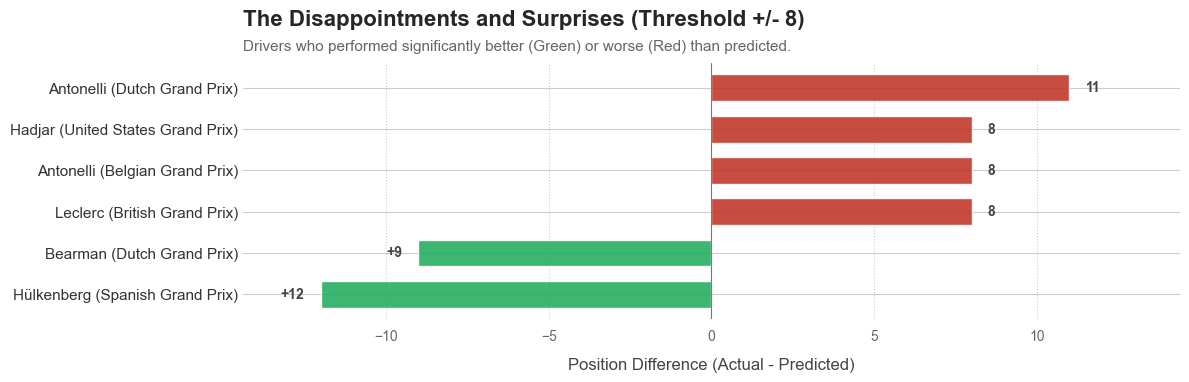

In [24]:
# Rename 'name' to 'GP_Name' if present to avoid merge conflicts
if 'name' in test_df.columns and 'GP_Name' not in test_df.columns:
    test_df.rename(columns={'name': 'GP_Name'}, inplace=True)

# Ensure driver names are present
if 'driver_name' not in drivers.columns:
    drivers['driver_name'] = drivers['forename'] + ' ' + drivers['surname']
if 'driver_name' not in test_df.columns:
    test_df = pd.merge(test_df, drivers[['driverId', 'driver_name']], on='driverId', how='left')

# Ensure GP names are present
if 'GP_Name' not in test_df.columns:
    test_df = pd.merge(test_df, races[['raceId', 'name']], on='raceId', how='left').rename(columns={'name': 'GP_Name'})

# Ensure round numbers are present
if 'round' not in test_df.columns:
    test_df = pd.merge(test_df, races[['raceId', 'round']], on='raceId', how='left')

# Select the best available prediction column
if 'best_ranking_model' in locals() and best_ranking_model:
    target_col = model_map[best_ranking_model]
else:
    available_preds = [c for c in test_df.columns if 'pred' in c and c != 'predicted_rank']
    target_col = available_preds[0] if available_preds else 'gradient_boosting_pred'

# Calculate ranks and error
test_df['predicted_rank'] = test_df.groupby('raceId')[target_col].rank(method='first', ascending=True)
test_df['error'] = test_df['positionOrder'] - test_df['predicted_rank']

# Set threshold for visualization
THRESHOLD = 8

# Filter for major errors
surprises = test_df[test_df['error'] <= -THRESHOLD][['driver_name', 'GP_Name', 'round', 'error']].copy()
disappointments = test_df[test_df['error'] >= THRESHOLD][['driver_name', 'GP_Name', 'round', 'error']].copy()

if surprises.empty and disappointments.empty:
    print(f"No errors found exceeding +/- {THRESHOLD} positions.")
else:
    # Prepare data for plotting
    viz_data = pd.concat([surprises, disappointments]).sort_values('error')

    # Create formatted labels: "Surname (Grand Prix Name)"
    # Example: "Hamilton (Dutch Grand Prix)"
    viz_data['label'] = (
        viz_data['driver_name'].apply(lambda x: x.split()[-1]) +
        " (" + viz_data['GP_Name'] + ")"
    )

    # Assign colors
    viz_data['color'] = np.where(viz_data['error'] < 0, '#27ae60', '#c0392b')

    # Plot
    plot_height = max(4, len(viz_data) * 0.5)
    fig, ax = plt.subplots(figsize=(12, plot_height))

    bars = ax.barh(viz_data['label'], viz_data['error'], color=viz_data['color'], height=0.65, alpha=0.9)

    # Styling
    ax.axvline(0, color='black', linewidth=0.8, alpha=0.5)
    ax.grid(axis='x', linestyle=':', alpha=0.4, color='gray')
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Adjust x-axis limits
    max_error = max(abs(viz_data['error'].min()), abs(viz_data['error'].max()))
    ax.set_xlim(-(max_error * 1.2), (max_error * 1.2))

    # Add annotations
    for bar, value in zip(bars, viz_data['error']):
        if value < 0:
            offset = -0.5
            align = 'right'
            text_str = f"+{abs(int(value))}"
        else:
            offset = 0.5
            align = 'left'
            text_str = f"{int(value)}"

        ax.text(value + offset, bar.get_y() + bar.get_height()/2,
                text_str, va='center', ha=align, fontsize=10, fontweight='bold', color='#444444')

    # Add titles and labels
    plt.text(0, 1.02 + (0.5/plot_height), f'The Disappointments and Surprises (Threshold +/- {THRESHOLD})',
             transform=ax.transAxes, fontsize=16, fontweight='bold', ha='left')
    plt.text(0, 1.00 + (0.2/plot_height), 'Drivers who performed significantly better (Green) or worse (Red) than predicted.',
             transform=ax.transAxes, fontsize=11, color='#666666', ha='left')

    ax.set_xlabel('Position Difference (Actual - Predicted)', fontsize=12, labelpad=10, color='#444444')
    ax.tick_params(axis='y', length=0, labelsize=11, labelcolor='#333333')
    ax.tick_params(axis='x', labelsize=10, colors='#666666')

    plt.tight_layout()
    plt.show()